In [1]:
!pip install xgboost

🏆 啟動「強勢股輪動」策略 (Alpha Rotation)...
   策略: 每週五選出 AI 認為最強的 2 支股票重倉，汰弱留強
 下載數據並計算相對強度...


C:\Users\johnn\AppData\Local\Temp\ipykernel_49380\1660704721.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download(BENCHMARK, start=START_DATE, end=END_DATE, progress=False)
C:\Users\johnn\AppData\Local\Temp\ipykernel_49380\1660704721.py:42: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
C:\Users\johnn\AppData\Local\Temp\ipykernel_49380\1660704721.py:42: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
C:\Users\johnn\AppData\Local\Temp\ipykernel_49380\1660704721.py:42: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
C:\Users\johnn\AppData\Local\Temp\ipykernel_49380\1660704721.py:42: FutureWarning: YF.download() has changed arg

 訓練排名模型 (Ranking Model)...
 執行 Top-2 輪動模擬...

 強勢股輪動績效 (本金 $10000)
1. 市場基準 (Hold All 7):
   - 最終資產: $35,214.48
   - 總獲利  : $25,214.48
   - 報酬率  : 252.14%
----------------------------------------
2. AI 輪動策略 (Top-2):
   - 最終資產: $58,080.90 
   - 總獲利  : $48,080.90
   - 報酬率  : 480.81%
----------------------------------------
 勝負判定:
    AI 擊敗大盤！超額報酬: $22,866.41


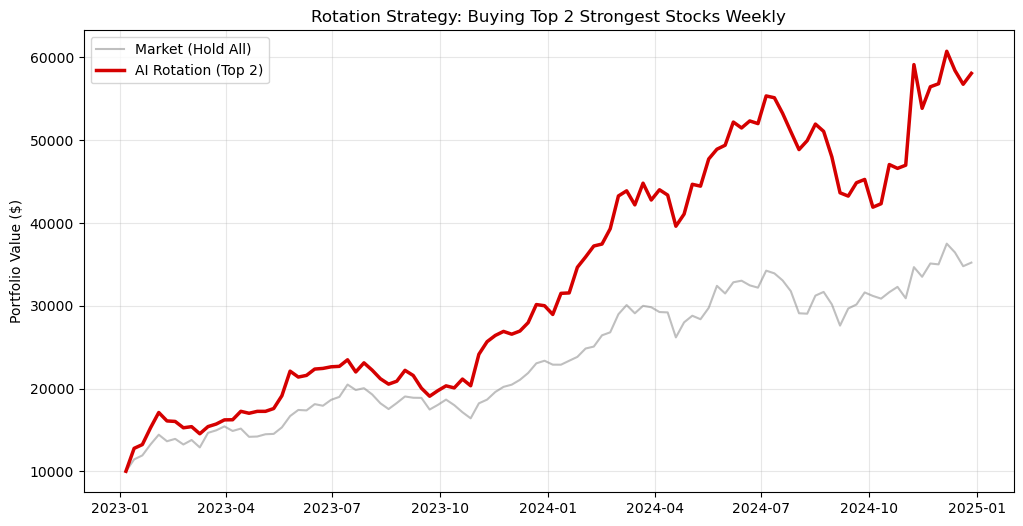


 最近 5 週的 AI 選股 (Top Picks):
          date         picks       ret
98  2024-11-29  [NFLX, META]  0.007459
99  2024-12-06  [NFLX, META]  0.070075
100 2024-12-13  [NFLX, NVDA] -0.037238
101 2024-12-20  [NVDA, MRNA] -0.027490
102 2024-12-27   [NFLX, AMD]  0.024257


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# ==========================================
# 1. 參數設定
# ==========================================
TICKERS = ['NVDA', 'AMD', 'TSLA', 'META', 'NFLX', 'COIN', 'MRNA']
BENCHMARK = 'SPY'
START_DATE = '2018-01-01'
END_DATE = '2024-12-31'
SPLIT_DATE = '2023-01-01' # 測試期拉長一點，包含 2023 初的起漲點
INITIAL_CAPITAL = 10000
TRANSACTION_COST = 0.001 
TOP_K = 2 #  每週只買最強的 2 支股票

print(f"🏆 啟動「強勢股輪動」策略 (Alpha Rotation)...")
print(f"   策略: 每週五選出 AI 認為最強的 {TOP_K} 支股票重倉，汰弱留強")

# ==========================================
# 2. 數據處理 (週線 + 相對強度)
# ==========================================
print(" 下載數據並計算相對強度...")

# 下載 SPY
spy = yf.download(BENCHMARK, start=START_DATE, end=END_DATE, progress=False)
if isinstance(spy.columns, pd.MultiIndex): spy.columns = spy.columns.get_level_values(0)
spy = spy.reset_index()[['Date', 'Close']]
spy.columns = ['date', 'spy_close']
spy['date'] = pd.to_datetime(spy['date']).dt.tz_localize(None)
spy.set_index('date', inplace=True)
spy_weekly = spy.resample('W-FRI').last().dropna()
# SPY 週收益率
spy_weekly['spy_ret'] = spy_weekly['spy_close'].pct_change()
spy_weekly = spy_weekly.reset_index()

all_data = []
for ticker in TICKERS:
    try:
        df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
        if df.empty: continue
        if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
        df = df.reset_index()
        df.columns = [c.lower() for c in df.columns]
        df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
        
        # 轉週線
        df.set_index('date', inplace=True)
        df_weekly = df.resample('W-FRI').agg({
            'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
        }).dropna()
        df_weekly = df_weekly.reset_index()
        df_weekly['ticker'] = ticker
        
        # 合併 SPY
        df_weekly = pd.merge(df_weekly, spy_weekly[['date', 'spy_ret']], on='date', how='left')
        
        # 計算特徵
        # 1. 個股週收益
        df_weekly['weekly_ret'] = df_weekly['close'].pct_change()
        # 2. 相對強度 (Alpha): 個股漲幅 - 大盤漲幅
        df_weekly['excess_ret'] = df_weekly['weekly_ret'] - df_weekly['spy_ret']
        
        # 3. 技術特徵
        df_weekly['rsi'] = 100 - (100 / (1 + df_weekly['close'].diff().clip(lower=0).rolling(14).mean() / df_weekly['close'].diff().clip(upper=0).abs().rolling(14).mean()))
        df_weekly['mom_4w'] = df_weekly['close'].pct_change(4) # 月動能
        df_weekly['volatility'] = df_weekly['weekly_ret'].rolling(12).std() # 季波動
        
        # 4. 預測目標: 下週是否「跑贏大盤」 (Outperform SPY)
        # 這裡我們不預測絕對漲跌，而是預測相對強弱
        df_weekly['target_excess'] = df_weekly['excess_ret'].shift(-1)
        df_weekly['target'] = (df_weekly['target_excess'] > 0).astype(int)
        
        all_data.append(df_weekly)
    except: pass

full_df = pd.concat(all_data).sort_values(['date', 'ticker']).reset_index(drop=True)
feature_cols = ['weekly_ret', 'excess_ret', 'rsi', 'mom_4w', 'volatility']
clean_df = full_df.dropna().reset_index(drop=True)

# ==========================================
# 3. 訓練模型 (Random Forest Ranking)
# ==========================================
train_df = clean_df[clean_df['date'] < SPLIT_DATE].copy()
test_df = clean_df[clean_df['date'] >= SPLIT_DATE].copy()

print(f" 訓練排名模型 (Ranking Model)...")
model = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=10, random_state=42, n_jobs=-1)
model.fit(train_df[feature_cols], train_df['target'])

# 獲取預測概率 (這代表 "跑贏大盤的信心分數")
test_df['score'] = model.predict_proba(test_df[feature_cols])[:, 1]

# ==========================================
# 4. 輪動回測 (Rotation Backtest)
# ==========================================
print(" 執行 Top-2 輪動模擬...")

# 我們需要按「週」進行迭代回測
dates = sorted(test_df['date'].unique())
portfolio_value = [INITIAL_CAPITAL]
market_value = [INITIAL_CAPITAL] # 用於對比 Buy & Hold 所有股票

# 記錄每週持倉
history = []

for i in range(len(dates)-1):
    curr_date = dates[i]
    next_date = dates[i+1]
    
    # 1. 獲取當週所有股票的預測分數
    current_week_data = test_df[test_df['date'] == curr_date].copy()
    
    # 如果數據不全 (例如這週只有 3 支股票有數據)，跳過
    if len(current_week_data) < TOP_K:
        portfolio_value.append(portfolio_value[-1])
        market_value.append(market_value[-1])
        continue
        
    # 2. 核心策略: 選出分數最高的 Top K
    top_picks = current_week_data.sort_values('score', ascending=False).head(TOP_K)
    selected_tickers = top_picks['ticker'].tolist()
    
    # 3. 計算下週收益 (Next Week Return)
    # 我們需要從完整數據中找到這些股票在 next_date 的收益
    next_week_data = test_df[test_df['date'] == next_date]
    
    # --- 策略收益計算 ---
    # 假設資金平均分配給 Top K
    strat_ret = 0
    valid_picks = 0
    for t in selected_tickers:
        # 找出該股票下週的實際收益
        stock_next = next_week_data[next_week_data['ticker'] == t]
        if not stock_next.empty:
            # 這裡用 simple return
            r = stock_next['weekly_ret'].values[0]
            strat_ret += r
            valid_picks += 1
            
    avg_strat_ret = strat_ret / valid_picks if valid_picks > 0 else 0
    
    # 扣除換倉成本 (簡化: 假設每週全換，雖然實際不一定)
    # 為了更真實，可以比較本週持有和上週持有的重疊度，這裡先從寬扣除
    final_strat_ret = avg_strat_ret - TRANSACTION_COST 
    
    portfolio_value.append(portfolio_value[-1] * (1 + final_strat_ret))
    history.append({'date': next_date, 'picks': selected_tickers, 'ret': avg_strat_ret})
    
    # --- 市場基準計算 (持有全部 7 支) ---
    market_ret = next_week_data['weekly_ret'].mean() # 等權重持有
    market_value.append(market_value[-1] * (1 + market_ret))

# ==========================================
# 5. 結果報告
# ==========================================
strat_final = portfolio_value[-1]
market_final = market_value[-1]
strat_profit = strat_final - INITIAL_CAPITAL
market_profit = market_final - INITIAL_CAPITAL

print("\n" + "="*40)
print(f" 強勢股輪動績效 (本金 ${INITIAL_CAPITAL})")
print("="*40)
print(f"1. 市場基準 (Hold All 7):")
print(f"   - 最終資產: ${market_final:,.2f}")
print(f"   - 總獲利  : ${market_profit:,.2f}")
print(f"   - 報酬率  : {(market_profit/INITIAL_CAPITAL)*100:.2f}%")
print("-" * 40)
print(f"2. AI 輪動策略 (Top-{TOP_K}):")
print(f"   - 最終資產: ${strat_final:,.2f} ")
print(f"   - 總獲利  : ${strat_profit:,.2f}")
print(f"   - 報酬率  : {(strat_profit/INITIAL_CAPITAL)*100:.2f}%")
print("-" * 40)
print(f" 勝負判定:")
if strat_final > market_final:
    print(f"    AI 擊敗大盤！超額報酬: ${(strat_final - market_final):,.2f}")
else:
    print(f"   AI 落後大盤。牛市太強了...")
print("="*40)

# 繪圖
plt.figure(figsize=(12, 6))
plt.plot(dates, market_value, label='Market (Hold All)', color='gray', alpha=0.5)
plt.plot(dates, portfolio_value, label=f'AI Rotation (Top {TOP_K})', color='#D50000', linewidth=2.5)
plt.title(f'Rotation Strategy: Buying Top {TOP_K} Strongest Stocks Weekly')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 顯示最後幾週的選股
print("\n 最近 5 週的 AI 選股 (Top Picks):")
hist_df = pd.DataFrame(history)
print(hist_df.tail(5)[['date', 'picks', 'ret']])